# Working Through Neural Networks for Optimal Statistical Inference (Poisson likelihoods+nuisance params) as Laid Out by Wunsch, Jorger, and Quast
- Cole Kampa
- 02-22-2021
- Paper: https://arxiv.org/abs/2003.07186

# Imports

In [232]:
import math
import numpy as np
import scipy.stats
import scipy.integrate
import matplotlib.pyplot as plt
%matplotlib inline

from plot_config import config_plots

In [233]:
config_plots()

In [234]:
# plot configs
plt.rcParams['figure.figsize'] = [10, 8] # larger figures
plt.rcParams['axes.grid'] = True         # turn grid lines on
plt.rcParams['axes.axisbelow'] = True    # put grid below points
plt.rcParams['grid.linestyle'] = '--'    # dashed grid
plt.rcParams.update({'font.size': 16.0})   # increase plot font size

# Section 4: Toy Example

- Generate data from a multivariate normal with 2 parameters $x_1, x_2$.
- Signal: $\mu_1 = \mu_2 = 0$
- Background: $\mu_1 = \mu_2 = 1$ with systematic variation that shifts mean along $x_2$ as $x_2 \pm 1$
- Covariance matrix (both): $ \begin{pmatrix} 1 & 0 \\ 0 & 1 \end{pmatrix}$

In [4]:
mu_s = np.array([0, 0])
mu_b = np.array([1, 1])
mu_b_u = np.array([1, 2])
mu_b_d = np.array([1, 0])
cov = np.array([[1,0],[0,1]])

In [350]:
#N = 100000 # 10^5 is quoted in paper
N = 100000
x1_s, x2_s = np.random.multivariate_normal(mu_s, cov, size=N).T
x1_b, x2_b = np.random.multivariate_normal(mu_b, cov, size=N).T

In [351]:
x1_ = np.concatenate([x1_s, x1_b])
x2_ = np.concatenate([x2_s, x2_b])

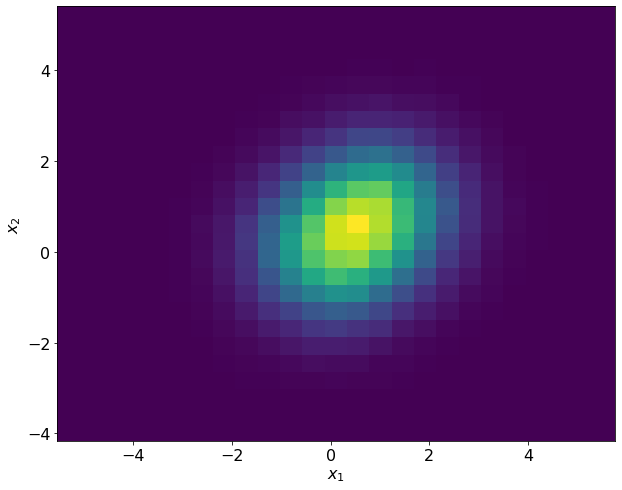

In [357]:
fig, ax = plt.subplots()
bins = 25
#ax.hist2d(x1_s, x2_s, bins=bins)
ax.hist2d(x1_, x2_, bins=bins)
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$');

In [359]:
np.mean(x1_), np.mean(x2_)

(0.5006359934735941, 0.5005504919928753)

- What about the PDFs? (Want to reconstruct figure 3).

In [18]:
scipy.stats.multivariate_normal.pdf([[1,0]], mean=mu_s, cov=cov)

0.09653235263005393

In [182]:
def int_wrapper(x1, x2, mean, cov):
    return scipy.stats.multivariate_normal.pdf([[x1, x2]], mean=mean, cov=cov)

def integrate_bin_poisson(x1_range, x2_range, mu, cov):
    return scipy.integrate.dblquad(int_wrapper, x1_range[0], x1_range[1],
                                   lambda x: x2_range[0], lambda x: x2_range[1], args=[mu, cov])

def integrate_bin_poisson_v2(x1_range, x2_range, mu, cov):
    c0 = scipy.stats.multivariate_normal.cdf([[x1_range[0],x2_range[0]]], mean=mu, cov=cov)
    c1 = scipy.stats.multivariate_normal.cdf([[x1_range[1],x2_range[1]]], mean=mu, cov=cov)
    c2 = scipy.stats.multivariate_normal.cdf([[x1_range[0],x2_range[1]]], mean=mu, cov=cov)
    c3 = scipy.stats.multivariate_normal.cdf([[x1_range[1],x2_range[0]]], mean=mu, cov=cov)
    return c0 + c1 - c2 - c3

In [83]:
%timeit integrate_bin_poisson([-0.4, 0], [-0.4, 0], mu_b, cov)

28.7 ms ± 188 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [84]:
%timeit integrate_bin_poisson_v2([-0.4, 0], [-0.4, 0], mu_b, cov)

357 µs ± 1.11 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [85]:
integrate_bin_poisson([-0.4, 0], [-0.4, 0], mu_b, cov), integrate_bin_poisson_v2([-0.4, 0], [-0.4, 0], mu_b, cov)

((0.006068191055874355, 2.0908616637498008e-16), 0.0060681910558743404)

- Using CDFs is way quicker (~100x!) and results are consistent
- Let's take one extra step and estimate bin count

In [183]:
def exp_bin_count_s_b(N_s, N_b, x1_range, x2_range, mu_s, mu_b, cov):
    count_s = N_s*integrate_bin_poisson_v2(x1_range, x2_range, mu_s, cov)
    count_b = N_b*integrate_bin_poisson_v2(x1_range, x2_range, mu_b, cov)
    return count_s, count_b

In [184]:
exp_bin_count_s_b(1e5, 1e5, [-0.4, 0], [-0.4, 0], mu_s, mu_b, cov),\
exp_bin_count_s_b(1e5, 1e5, [-0.4, 0], [-0.4, 0], mu_s, mu_b_u, cov),\
exp_bin_count_s_b(1e5, 1e5, [-0.4, 0], [-0.4, 0], mu_s, mu_b_d, cov)

((2415.5917765186387, 606.819105587434),
 (2415.5917765186387, 113.36267794402573),
 (2415.5917765186387, 1210.7135256911122))

In [102]:
s, b = exp_bin_count_s_b(1e5, 1e5, [-0.4, 0], [-0.4, 0], mu_s, mu_b, cov)

In [103]:
s, b

(2415.5917765186387, 606.819105587434)

In [106]:
s+b

3022.4108821060727

In [314]:
def NLL_p(n, mu, s, b):
    return -n*np.log(mu*s+b) + (mu*s+b)

In [321]:
def NLL_bin(mu, muprime, d, N_s, N_b, x1_range, x2_range, mu_s, mu_b, cov):
    # d = observed bin count
    s, b = exp_bin_count_s_b(N_s, N_b, x1_range, x2_range, mu_s, mu_b, cov)
    #s = int(s)
    #b = int(b)
    if d == 'asimov':
        #d = int(mu * s + b)
        #d = int(muprime * s + b)
        d = mu * s + b
    #print(s, b, d)
    NLL = -d * np.log(muprime * s + b) + (muprime*s + b)
    #NLL = -np.log(scipy.stats.poisson.pmf(k=d, mu=mu*s + b))
    return NLL

def L_bin(mu, muprime, d, N_s, N_b, x1_range, x2_range, mu_s, mu_b, cov):
    # d = observed bin count
    s, b = exp_bin_count_s_b(N_s, N_b, x1_range, x2_range, mu_s, mu_b, cov)
    #s = int(s)
    #b = int(b)
    if d == 'asimov':
        #d = int(mu * s + b)
        d = int(muprime * s + b)
        #d = mu * s + b
    #print(s, b, d)
    L = scipy.stats.poisson.pmf(k=d, mu=mu*s + b)
    return L

In [155]:
NLL_bin(1, 2000, 1e5, 1e5, [-0.4, 0], [-0.4, 0], mu_s, mu_b, cov), NLL_bin(1, 3022, 1e5, 1e5, [-0.4, 0], [-0.4, 0], mu_s, mu_b, cov)

(201.31503816821532, 4.9258311101584695)

In [216]:
NLL_bin(1, 0.5, 'asimov', 1e5, 1e5, [-0.4, 0], [-0.4, 0], mu_s, mu_b, cov)

286.99738507054826

In [217]:
L_bin(1, 0.5, 'asimov', 1e5, 1e5, [-0.4, 0], [-0.4, 0], mu_s, mu_b, cov)

2.2835963658806677e-125

In [313]:
def NLL_p(n, mu, s, b):
    return -n*np.log(mu*s+b) + (mu*s+b)

In [229]:
NLL(1, 1000, 100, 1100, 1000, 1)

OverflowError: integer division result too large for a float

In [401]:
def NLL_all_bins_asimov(mu, muprime, N_s, N_b, edges_x1, edges_x2, mu_s, mu_b, cov):
    #nbins = (len(edges_x1)-1) * (len(edges_x2)-1)
    #for i in range(len(edges_x1)-1):
    NLL = 0.
    #L = 1.
    for i in range(len(edges_x1)-1):
        #print(NLL)
        for j in range(len(edges_x2)-1):
            x1_range = edges_x1[i:i+2]
            x2_range = edges_x2[j:j+2]
            #print(x1_range, x2_range)
            NLL_ = NLL_bin(mu, muprime, 'asimov', N_s, N_b, x1_range, x2_range, mu_s, mu_b, cov)
            #NLL_ = NLL_p(muprime, )
            NLL += NLL_
            #print(NLL)
            #L_ = L_bin(mu, muprime, 'asimov', N_s, N_b, x1_range, x2_range, mu_s, mu_b, cov)
            #L *= L_
    return NLL
    #return -np.log(L)
    
def find_NLL_unc(mu, N_s, N_b, edges_x1, edges_x2, mu_s, mu_b, cov, dNLL=0.5, eps=1e-2, dmu0=0.1):
    # base value
    N0 = NLL_all_bins_asimov(mu, mu, N_s, N_b, edges_x1, edges_x2, mu_s, mu_b, cov)
    # find upper
    sign = 1
    dmu = dmu0
    mu_ = mu+sign*dmu
    N_ = NLL_all_bins_asimov(mu, mu_, N_s, N_b, edges_x1, edges_x2, mu_s, mu_b, cov)
    dN = N_ - N0
    i = 0
    while (abs(dN-dNLL) > eps):
#         if i % 10 == 0:
#             print(f'iter {i}, mu_ {mu_}, dNLL {dN}')
        if (dN < dNLL):
            sign_ = 1
        else:
            sign_ = -1
        if sign_ == sign:
            sign = sign_
        else:
            dmu *= 0.1
            sign = sign_
        mu_ = mu_+sign*dmu
        N_ = NLL_all_bins_asimov(mu, mu_, N_s, N_b, edges_x1, edges_x2, mu_s, mu_b, cov)
        dN = N_ - N0
        i += 1
    mu_u = mu_
#     print(f'mu_u = {mu_u}')
    # find lower
    sign = -1
    dmu = dmu0
    mu_ = mu+sign*dmu
    N_ = NLL_all_bins_asimov(mu, mu_, N_s, N_b, edges_x1, edges_x2, mu_s, mu_b, cov)
    dN = N_ - N0
    i = 0
    while (abs(dN-dNLL) > eps):
#         if i % 10 == 0:
#             print(f'iter {i}, mu_ {mu_}, dNLL {dN}')
        if (dN < dNLL):
            sign_ = -1
        else:
            sign_ = 1
        if sign_ == sign:
            sign = sign_
        else:
            dmu *= 0.1
            sign = sign_
        mu_ = mu_+sign*dmu
        N_ = NLL_all_bins_asimov(mu, mu_, N_s, N_b, edges_x1, edges_x2, mu_s, mu_b, cov)
        dN = N_ - N0
        i += 1
    mu_d = mu_
    return mu_d, mu_u

In [402]:
edges_x1 = np.linspace(-3, 5, 21)
edges_x2 = np.linspace(-3, 5, 21)

In [403]:
## THIS CELL GIVES MU_STAT FROM FIG 4
find_NLL_unc(1, 50, 1000, edges_x1, edges_x2, mu_s, mu_b, cov, dNLL=0.5, eps=1e-2, dmu0=0.1)

(0.6800000000000002, 1.343)

In [404]:
1 - 0.68

0.31999999999999995

In [381]:
N0 = NLL_all_bins_asimov(1, 1, 50, 1e3, edges_x1, edges_x2, mu_s, mu_b, cov)

In [390]:
2*(NLL_all_bins_asimov(1, 1.50-.125-.125, 50, 1e3, edges_x1, edges_x2, mu_s, mu_b, cov) - N0)

0.5326659982483761

In [340]:
edges_x1 = np.linspace(-3, 5, 21)
edges_x2 = np.linspace(-3, 5, 21)
#edges_x1 = np.linspace(-3, 5, 9)
#edges_x2 = np.linspace(-3, 5, 9)

In [341]:
N0 = NLL_all_bins_asimov(1, 0, 1e5, 1e5, edges_x1, edges_x2, mu_s, mu_b, cov)
N1 = NLL_all_bins_asimov(1, 1, 1e5, 1e5, edges_x1, edges_x2, mu_s, mu_b, cov)

In [342]:
(N0-N1) / 400

241.4153893729468

In [324]:
edges_x1

array([-3. , -2.6, -2.2, -1.8, -1.4, -1. , -0.6, -0.2,  0.2,  0.6,  1. ,
        1.4,  1.8,  2.2,  2.6,  3. ,  3.4,  3.8,  4.2,  4.6,  5. ])

In [364]:
#mus = np.linspace(0.4, 1.6, 13)
mus = np.linspace(0.6, 1.4, 81)
NLLs = []
for mup in mus:
    #print(mu)
    NLLs.append(NLL_all_bins_asimov(1, mup, 50, 1000, edges_x1, edges_x2, mu_s, mu_b, cov))
NLLs = np.array(NLLs)

In [366]:
mus

array([0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.7 ,
       0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.8 , 0.81,
       0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9 , 0.91, 0.92,
       0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1.  , 1.01, 1.02, 1.03,
       1.04, 1.05, 1.06, 1.07, 1.08, 1.09, 1.1 , 1.11, 1.12, 1.13, 1.14,
       1.15, 1.16, 1.17, 1.18, 1.19, 1.2 , 1.21, 1.22, 1.23, 1.24, 1.25,
       1.26, 1.27, 1.28, 1.29, 1.3 , 1.31, 1.32, 1.33, 1.34, 1.35, 1.36,
       1.37, 1.38, 1.39, 1.4 ])

In [367]:
np.argwhere(np.isclose(mus, 1.))

array([[40]])

Text(0, 0.5, '$2 \\cdot \\Delta \\mathrm{NLL}$')

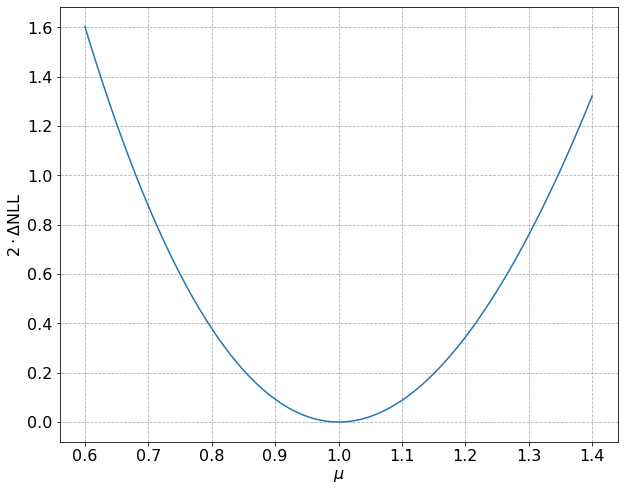

In [368]:
fig, ax = plt.subplots()
#ax.plot(mus, 2*NLLs/NLLs[6] - 2)
#ax.plot(mus, 2*(NLLs-NLLs[6]))
ax.plot(mus, 2*(NLLs-NLLs[40]))

#le = ax.legend(loc='best')
#le.set_zorder(121)
ax.set_xlabel(r'$\mu$')
ax.set_ylabel(r'$2 \cdot \Delta \mathrm{NLL}$')
#ax.set_ylabel(r'$\mathrm{NLL}$')
#ax.set_title('Signal and Background Distributions (Section 4)');

In [369]:
D_NLLs = 2*(NLLs-NLLs[40])

In [375]:
1-mus[D_NLLs < 1.0][0]

0.31000000000000005

In [377]:
mus[(mus>1.) & (D_NLLs > 1.0)][0] - 1

0.34999999999999987

In [379]:
50*mus[D_NLLs < 1.0][0], 50*mus[(mus>1.) & (D_NLLs > 1.0)][0]

(34.5, 67.5)

- These values match up reasonably close to the values from the paper Fig. 4 of $\mu_\mathrm{stat.} = 1.00\ (-0.32 + 0.34)$

In [192]:
NLL_all_bins_asimov(1, 1e5, 1e5, edges_x1, edges_x2, mu_s, mu_b, cov)

242.69717911607873

In [163]:
edges_x1

array([-3. , -2.6, -2.2, -1.8, -1.4, -1. , -0.6, -0.2,  0.2,  0.6,  1. ,
        1.4,  1.8,  2.2,  2.6,  3. ,  3.4,  3.8,  4.2,  4.6,  5. ])

In [74]:
8 / 20

0.4

In [76]:
400 * 28.8e-3

11.52

In [49]:
x1s = np.linspace(-3, 5, 81)
x2s = np.linspace(-3, 5, 81)
X1, X2 = np.meshgrid(x1s, x2s)
POS = np.vstack([X1.ravel(), X2.ravel()]).T

In [53]:
f_S = scipy.stats.multivariate_normal.pdf(POS, mean=mu_s, cov=cov).reshape(len(x2s),len(x1s))
f_B = scipy.stats.multivariate_normal.pdf(POS, mean=mu_b, cov=cov).reshape(len(x2s),len(x1s))
f_B_u = scipy.stats.multivariate_normal.pdf(POS, mean=mu_b_u, cov=cov).reshape(len(x2s),len(x1s))
f_B_d = scipy.stats.multivariate_normal.pdf(POS, mean=mu_b_d, cov=cov).reshape(len(x2s),len(x1s))

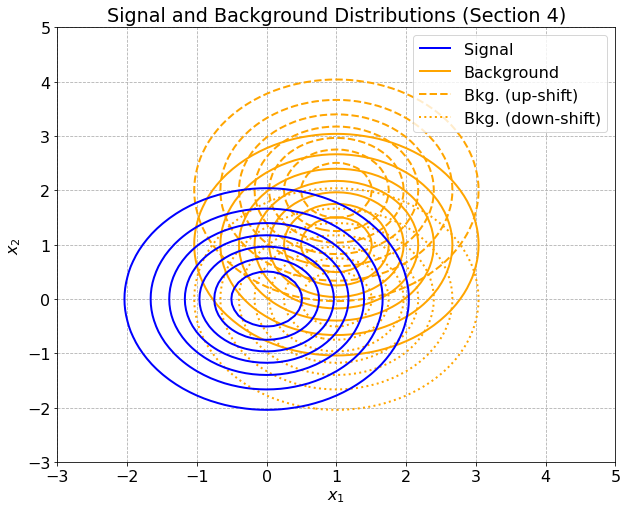

In [64]:
fig, ax = plt.subplots()
Cs = ax.contour(X1, X2, f_S, colors='blue', linewidths=2, zorder=120)
Cb = ax.contour(X1, X2, f_B, colors='orange', linewidths=2, zorder=119)
Cbu = ax.contour(X1, X2, f_B_u, colors='orange', linewidths=2, linestyles='dashed', zorder=118)
Cbd = ax.contour(X1, X2, f_B_d, colors='orange', linewidths=2, linestyles='dotted', zorder=117)

labels=['Signal', 'Background', 'Bkg. (up-shift)', 'Bkg. (down-shift)']
Cs = [Cs, Cb, Cbu, Cbd]

for l, C in zip(labels, Cs):
    C.collections[0].set_label(l)

le = ax.legend(loc='best')
le.set_zorder(121)
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
ax.set_title('Signal and Background Distributions (Section 4)');

# Simple 1D Poisson Likelihood

In [288]:
mu = 1
s = 10
b = 100
n = mu*s+b

In [289]:
mu*s+b

110

In [290]:
n = 110
n * np.log(mu*s + b) - mu

516.0528402371658

In [291]:
def NLL_poisson(muprime, s, b, n):
    return -n*np.log(muprime*s+b) + (muprime*s+b)

In [292]:
def poisson_pmf(n, mu, s, b):
    mu_ = mu*s + b
    return mu_**(n) * np.exp(-mu_) / math.factorial(n)

In [293]:
poisson_pmf(mu*s+b, 1, s, b), -np.log(poisson_pmf(mu*s+b, 1, s, b))

(0.03800884855046252, 3.2699362897715205)

In [294]:
poisson_pmf(100, 1, s, b), -np.log(poisson_pmf(100, 1, s, b))

(0.0249385874984657, 3.6913389763218674)

In [295]:
NLL_poisson(20, s, b, n)

-327.41607221218214

In [311]:
mus = np.linspace(-1, 3, 1000)
NLLs = []
for mu_ in mus:
    NLLs.append(NLL_poisson(mu_, s, b, n))
NLLs = np.array(NLLs)

In [306]:
mu

1

In [307]:
NLL0 = NLL_poisson(mu, s, b, n)

In [308]:
NLL0

-407.0528402371658

Text(0, 0.5, '$\\mathrm{NLL}$')

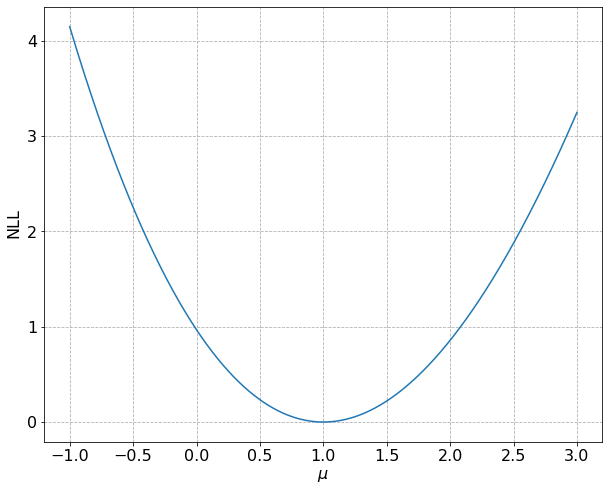

In [312]:
fig, ax = plt.subplots()
ax.plot(mus, 2*(NLLs - NLL0))

ax.set_xlabel(r'$\mu$')
ax.set_ylabel(r'$\mathrm{NLL}$')
#ax.set_ylabel(r'$2 \cdot \Delta \mathrm{NLL}$')

In [310]:
n * np.log(mu*s + b)

517.0528402371658